In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare

# Задача
Оцените результаты эксперимента: 
1. Стат значимо ли отличается ARPU в двух группах? 
2. Какие рекомендации дадите менеджеру?

## Поработаем с датасетом c покупками
Метрики
* ARPU или Average Revenue Per User - является производным показателем, рассчитывается как средневзвешенное за период агрегации значение Платежи LT/Регистрации. Отображает прибыль, полученную нами с 1 регистрации пользователя, также известен.

* ARPPU или Average Revenue Per Paying User - средний платеж платящего пользователя. Рассчитывается как средневзвешенное значение (Платежи LT/Впервые заплативших LT) за период агрегации. Показывает, сколько, в среднем, платит пользователь, ставший платящим, и, зарегистрированный в период агрегации, за всю жизнь.



### Подготовка данных

In [3]:
df = pd.read_csv('ab_stats.csv', sep=',')
df.head()

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [5]:
df.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [6]:
df[df['av_site visit']<0]

,revenue,num_purchases,purchase,ab_group,av_site visit
1789,0.0,0,0,A,-12.073486
1856,0.0,0,0,A,-0.683411
5122,0.0,0,0,A,-0.045455
7109,0.0,0,0,A,-12.073486
8118,0.0,0,0,A,-0.126946
...,...,...,...,...,...
23567,0.0,0,0,B,-3.901748
23606,0.0,0,0,B,-2.284448
23626,0.0,0,0,B,-3.528928
23634,0.0,0,0,B,-1.708265


In [7]:
df[df['av_site visit']<0].purchase.sum()

10

In [8]:
df[(df['av_site visit']<0) & (df['ab_group']== 'B')].purchase.sum()

10

In [9]:
df[(df['av_site visit']<0) & (df['ab_group']== 'B')].purchase.count()

462

In [10]:
df[(df['av_site visit']<0)& (df['ab_group']== 'A')].purchase.count()

6

Получили примерно 2% users с некоректными данными. Т.е есть баг в группе В, который что-то неправильно считает. \
Соответственно т.к. у нас выборка из 23652 user, то мы можем их исключить из теста

In [11]:
df = df[(df['av_site visit']>=0)]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23184 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23184 non-null  float64
 1   num_purchases  23184 non-null  int64  
 2   purchase       23184 non-null  int64  
 3   ab_group       23184 non-null  object 
 4   av_site visit  23184 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.1+ MB


In [13]:
df.ab_group.value_counts()

ab_group
A    11829
B    11355
Name: count, dtype: int64

In [57]:
df[df['purchase']==1]

,revenue,num_purchases,purchase,ab_group,av_site visit
45,1.885595,1,1,A,7.654627
54,1.002159,1,1,A,6.392489
82,2.990000,1,1,A,8.596604
104,49.990000,1,1,A,8.885633
110,22.093757,4,1,A,8.708759
...,...,...,...,...,...
23426,2.489611,1,1,B,9.015714
23493,74.950000,5,1,B,5.881950
23495,3.667866,1,1,B,7.450014
23584,19.990000,1,1,B,9.813696


Посмотрим на группы отдельно

In [58]:
df[df['ab_group']=='A'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11829.000000,11829.000000,11829.000000,11829.000000
mean,0.404667,0.050723,0.021642,6.980379
std,13.136545,1.467883,0.145517,2.004450
min,0.000000,0.000000,0.000000,0.145466
25%,0.000000,0.000000,0.000000,5.657590
50%,0.000000,0.000000,0.000000,6.984166
75%,0.000000,0.000000,0.000000,8.346243
max,1303.609284,152.000000,1.000000,17.728836


In [59]:
df[df['ab_group']=='B'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11355.000000,11355.000000,11355.000000,11355.000000
mean,0.245093,0.036548,0.019727,7.404806
std,3.192299,0.422820,0.139067,3.630412
min,0.000000,0.000000,0.000000,0.008679
25%,0.000000,0.000000,0.000000,4.746728
50%,0.000000,0.000000,0.000000,7.262590
75%,0.000000,0.000000,0.000000,9.889165
max,113.830000,25.000000,1.000000,22.446822


Группа A показывает себя лучше

Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в первой группе сильно больше, чем в группе B. \
Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

### Проверка на нормальность распределения и применение статистических критериев

#### Метрика визиты на юзера

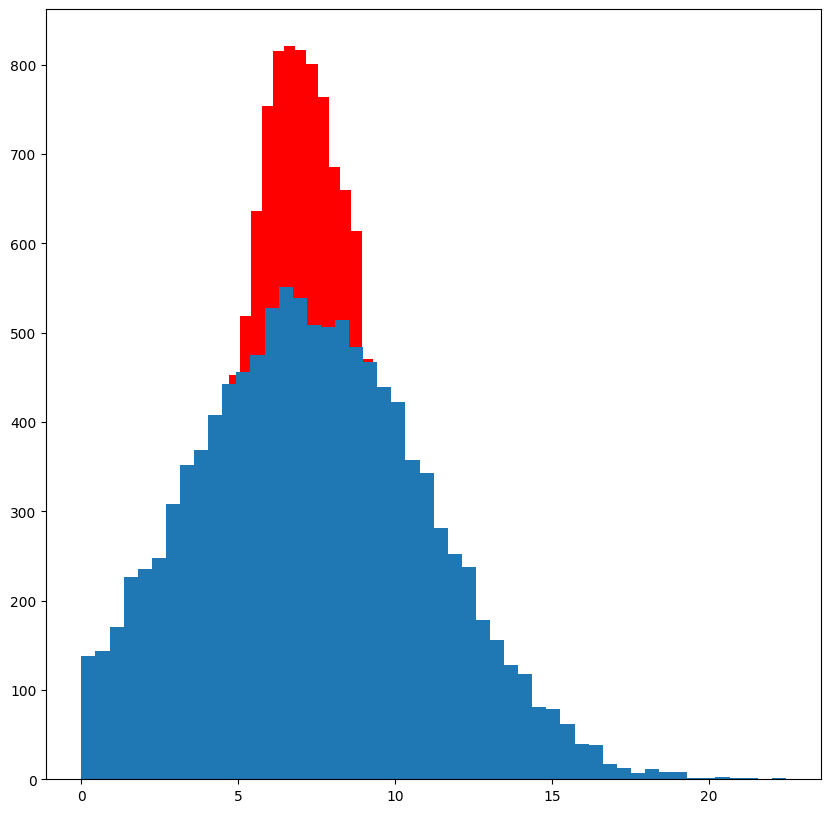

In [112]:
plt.figure(figsize=(10, 10))
control_visit_all = df['av_site visit'][df['ab_group'] == 'A']
test_visit_all = df['av_site visit'][df['ab_group'] == 'B']

plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all,  bins=50)

plt.show()

In [113]:
stats.ttest_ind(control_visit_all, test_visit_all, equal_var = False)

Ttest_indResult(statistic=-10.957295422202266, pvalue=7.548128551839559e-28)

In [115]:
if 7.55 > 0.05:
   print('Нулевая гипотеза - нет статистически значимых различий')
else:
   print('Альтернативная гипотеза – есть статистически значимые различия')

Нулевая гипотеза - нет статистически значимых различий


#### Метрика доля юзеров с покупкой

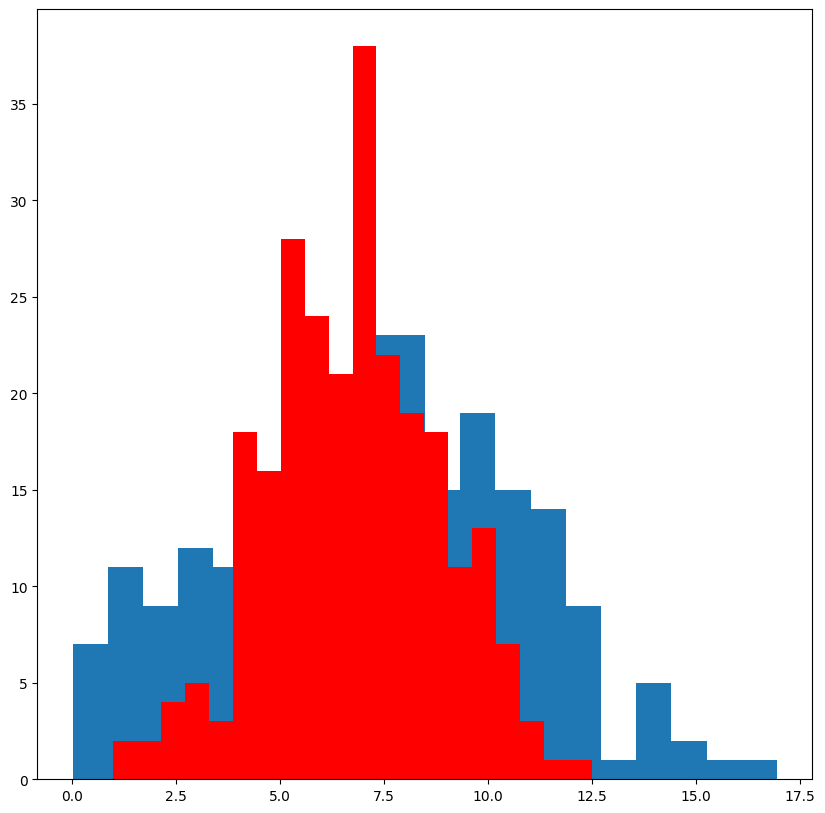

In [116]:
plt.figure(figsize=(10, 10))
control_visit = df['av_site visit'][(df['ab_group'] == 'A')&(df['purchase'] == 1)]
test_visit =df['av_site visit'][(df['ab_group'] == 'B')&(df['purchase'] == 1)]
plt.hist(test_visit, bins=20)
plt.hist(control_visit, color='r', bins=20)

plt.show()

In [118]:
stats.ttest_ind(control_visit, test_visit, equal_var = False)

Ttest_indResult(statistic=-1.8346992509618332, pvalue=0.06740860216409701)

In [119]:
if 0.067 > 0.05:
   print('Нулевая гипотеза - нет статистически значимых различий')
else:
   print('Альтернативная гипотеза – есть статистически значимые различия')

Нулевая гипотеза - нет статистически значимых различий


In [124]:
df['purchase'].value_counts()

purchase
0    22704
1      480
Name: count, dtype: int64

In [121]:
k1 = df[df['ab_group']=='A']['purchase'].sum()
k2 = df[df['ab_group']=='B']['purchase'].sum()

print(k1, k2)

256 224


In [86]:
n1 = df[df['ab_group']=='A'].shape[0]
n2 = df[df['ab_group']=='B'].shape[0]

print(n1, n2)

11829 11355


In [125]:
# z-тест
z_score, z_pvalue = proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))
print('Результаты:','z_score = %.3f, pvalue = %.3f'%(z_score, z_pvalue))

if abs(z_pvalue) > 0.05:
   print('Нулевая гипотеза - Между конверсией в двух группах нет статистически значимых различий')
else:
   print('Альтернативная гипотеза – Между конверсией в двух группах есть статистически значимые различия')

Результаты: z_score = 1.024, pvalue = 0.306
Нулевая гипотеза - Между конверсией в двух группах нет статистически значимых различий


In [123]:
# непараметрический Хи-квадрат
chisq, pvalue, table = proportions_chisquare(np.array([k1, k2]), np.array([n1, n2]))
print('Результаты:','chisq = %.3f, pvalue = %.3f'%(chisq, pvalue))

if abs(pvalue) > 0.05:
   print('Нулевая гипотеза - Между конверсией в двух группах нет статистически значимых различий')
else:
   print('Альтернативная гипотеза – Между конверсией в двух группах есть статистически значимые различия')

Результаты: chisq = 1.048, pvalue = 0.306
Нулевая гипотеза - Между конверсией в двух группах нет статистически значимых различий


#### Метрика arpu

In [107]:
df.groupby('ab_group')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
ab_group,,,,,,,,
A,11829.0,0.404667,13.136545,0.0,0.0,0.0,0.0,1303.609284
B,11355.0,0.245093,3.192299,0.0,0.0,0.0,0.0,113.830000


In [111]:
# непараметрический критерий Манн-Уитни
mw_stats = stats.mannwhitneyu(x=df[(df['ab_group'] == 'A')&(df['purchase'] == 1)]['revenue'].values,
                                                  y=df[(df['ab_group'] == 'B')&(df['purchase'] == 1)]['revenue'].values)

mw_stats
#ARPPU - средняя выручка на платящих users
# 4+5+6/3

MannwhitneyuResult(statistic=28485.5, pvalue=0.902319344132039)

In [126]:
mw_stats = stats.mannwhitneyu(x=df[(df['ab_group'] == 'A')]['revenue'].values,
                                                  y=df[(df['ab_group'] == 'B')]['revenue'].values)

mw_stats
#ARPU - средняя выручка на всех users
# 0+4+5+0+6+0/6

MannwhitneyuResult(statistic=67287553.0, pvalue=0.306808963067974)

Решение с помощью Bootstrap

Гипотезы:  
  
H0: Набор статистически значимо не влияет (p-value > 0.05)  
H1: Набор статистически значимо влияет (p-value < 0.05)  

In [132]:
from tqdm.auto import tqdm #для красивой полоски

plt.style.use('ggplot')

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

100%|██████████| 10000/10000 [00:01<00:00, 5356.37it/s]


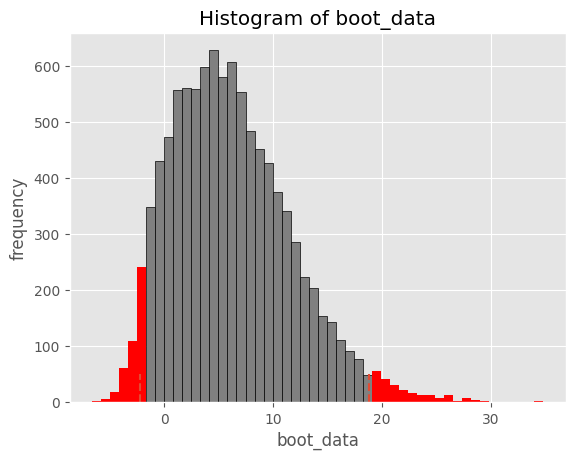

{'p_value': 0.2627944605990076}

In [133]:
get_bootstrap(df[(df['ab_group'] == 'A')&(df['purchase'] == 1)]['revenue'], df[(df['ab_group'] == 'B')&(df['purchase'] == 1)]['revenue'])

100%|██████████| 10000/10000 [00:07<00:00, 1424.55it/s]


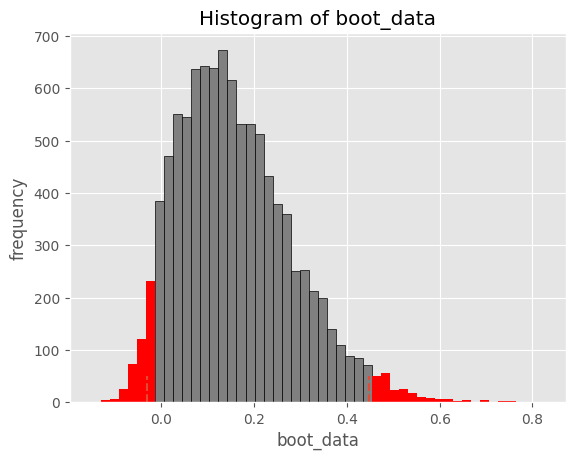

{'p_value': 0.1996839901366212}

In [134]:
get_bootstrap(df[(df['ab_group'] == 'A')]['revenue'], df[(df['ab_group'] == 'B')]['revenue'])

## Немного инфы bootstrap

**scipy.stats**  
функция scipy.stats.bootstrap(), появившаяся с версии 1.7.0. Содержит в себе ряд аргументов, но наиболее важные таковы:

* data — данные. Принимает их на вход в виде списка (квадратные скобки) или кортежа (круглые скобки), даже если группа только одна — в случае одной группы данные подаются как (data, );  
* statistic — функция, которая считает нужный нам параметр. Если на вход идёт две или больше групп, то функция также должна принимать на вход два или больше аргументов и возвращать какое-то одно число;  
* n_resamples — количество симуляций. По умолчанию 9999 (почти 10000) - можно понизить, если не хватает вычислительных мощностей, или повысить, если хочется увеличить точность;  
* confidence_level — уровень значимости, по умолчанию 95%;
method — алгоритм расчёта доверительного интервала. Метод по умолчанию обычно справляется лучше своих аналогов, но при необходимости можно менять.   
  
**pingouin**  
В этом пакете есть функция pingouin.compute_bootci(), во многом похожая на аналогичную из scipy - но с более простым интерфейсом, рядом встроенных метрик (смотрите описание аргумента func) и немного другим набором алгоритмов бутстрапа.

**bootstrapped**  
Библиотека от Facebook, в большей степени ориентирована на применение бутстрапа в контексте индустрии. Репозиторий содержит в себе папку с ноутбуками для демонстрации всего, что умеет делать эта библиотека.

**wildboottest**  
Эта библиотека позволяет оценивать статзначимость коэффициентов регрессионной модели с помощью бутстрапа и работает вместе со statsmodels. В частности, пакет реализует алгоритм т.н. “дикого бутстрапа”, более устойчивого к нарушениям гомоскедастичности.

# Результат
1. Нет созначимых различий ARPU. 
2. Версия B показывает себя по хуже версии А. Нет смысла выкатывать версию В. Тем более в версии B присутствуют баги. 